## Retinal Blood vessel segmentation using a CNN

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
Train = True  #switch for training

# Loading and preparing data

In [ ]:
import os
import numpy as np
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
print(tf.__version__)

2.9.2


In [ ]:
np.random.seed(70)
tf.random.set_seed(70)

In [ ]:
data_path = '/content/gdrive/MyDrive/IT402/dataset/training/'
output_path = '/content/gdrive/MyDrive/IT402/output/'

image_width = 565
image_height = 584

In [ ]:
img_data_path = os.path.join(data_path, 'images')
seg_data_path = os.path.join(data_path, '1st_manual')
print(img_data_path)
print(seg_data_path) 

/content/gdrive/MyDrive/IT402/dataset/training/images
/content/gdrive/MyDrive/IT402/dataset/training/1st_manual


In [ ]:
def create_data_arr(img_data_path):
  images = sorted(os.listdir(img_data_path))
  num_images = len(images)
  imgs_array = np.ndarray((num_images, image_width, image_height), dtype=np.uint8)

  n = 0
  good_imgs=[]
  for image_name in images:
      img = Image.open(os.path.join(img_data_path,image_name)).convert('L') 
      good_imgs.append(image_name)
      img = np.array(img.resize((image_height,image_width)))
      imgs_array[n] = img
      n +=1
  return imgs_array

print('Creating training images array...')
imgs_array = create_data_arr(img_data_path)
np.save(output_path + 'imgs_train.npy', imgs_array)
print(imgs_array.shape)

print('Creating training masks array...')
segs_array = create_data_arr(seg_data_path)
np.save(output_path + 'seg_train.npy', segs_array)
print(segs_array.shape)


Creating training images array...
(20, 565, 584)
Creating training masks array...
(20, 565, 584)


(20, 565, 584)
(20, 565, 584)


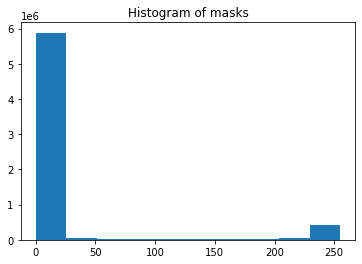

In [ ]:
del imgs_array
del segs_array

imgs = np.load(output_path + 'imgs_train.npy')
segs = np.load(output_path + 'seg_train.npy')

hh = plt.hist(segs.flatten())
plt.title("Histogram of masks")

img_no=11
print(imgs.shape)
w=Image.fromarray(imgs[img_no].reshape(image_width,image_height))
#display(w)

print(segs.shape)
w=Image.fromarray(segs[img_no].reshape(image_width,image_height))
#display(w)

In [ ]:
def create_patches(imgs,segs, patch_size=128, step_size=16):
  #making patches of size patch_size*patch_size and stride=step_size
  from skimage.util.shape import view_as_windows

  imgs_patches = np.array([])
  segs_patches = np.array([])
  for i in range(imgs.shape[0]):
    patches=view_as_windows(imgs[i], (patch_size, patch_size), step=step_size)
    patches=patches.reshape(-1,patch_size,patch_size)
    seg_pats=view_as_windows(segs[i], (patch_size, patch_size), step=step_size)
    seg_pats=seg_pats.reshape(-1,patch_size,patch_size)
  
    if i==0:
      #first run
      imgs_patches=patches
      segs_patches=seg_pats
    else:
      imgs_patches=np.append(imgs_patches,patches,axis=0)
      segs_patches=np.append(segs_patches,seg_pats,axis=0)

  imgs_patches = imgs_patches[:,:,:,np.newaxis]
  segs_patches = segs_patches[:,:,:,np.newaxis]

  imgs_patches = imgs_patches.astype('float32')
  imgs_patches /=255.0
  segs_patches = segs_patches.astype('float32')
  segs_patches /=255.0

  return imgs_patches,segs_patches

In [ ]:
#Splitting the data
train_imgs, valid_test_imgs, train_segs, valid_test_segs = \
                    train_test_split(imgs, segs, test_size=0.5, random_state=54)

valid_imgs, test_imgs, valid_segs, test_segs = \
                    train_test_split(valid_test_imgs, valid_test_segs, test_size=0.5, random_state=54)

print(train_imgs.shape,train_segs.shape, valid_imgs.shape,valid_segs.shape,test_imgs.shape,test_segs.shape)

#Creating patches
TrainPatchImg, TrainPatchSeg = create_patches(train_imgs,train_segs ,step_size=8)
ValidPatchImg, ValidPatchSeg = create_patches(valid_imgs,valid_segs, step_size=128)
TestPatchImg, TestPatchSeg = create_patches(test_imgs,test_segs, step_size=128)
TrainPatchImgEval, TrainPatchSegEval = create_patches(train_imgs,train_segs ,step_size=128)
print(TrainPatchImg.shape,TrainPatchSeg.shape, ValidPatchImg.shape,ValidPatchSeg.shape,TestPatchImg.shape,TestPatchSeg.shape,TrainPatchImgEval.shape)

(10, 565, 584) (10, 565, 584) (5, 565, 584) (5, 565, 584) (5, 565, 584) (5, 565, 584)
(31900, 128, 128, 1) (31900, 128, 128, 1) (80, 128, 128, 1) (80, 128, 128, 1) (80, 128, 128, 1) (80, 128, 128, 1) (160, 128, 128, 1)


# Training

Model architecture

In [ ]:
def BN_ReLU(input_features): 
    output_features = BatchNormalization()(input_features)
    output_features = relu(output_features)
    return output_features 

def Model_Architecture(input_layer):
    initial_num_filters=16
    input_layer = BatchNormalization()(input_layer)  #sd
    #in:128--out:64
    conv1 = Conv2D(initial_num_filters * 1, (3, 3), padding="same")(input_layer)
    out = BN_ReLU(conv1) 
    out = MaxPooling2D((2, 2))(out)  
    out = Dropout(0.2)(out)
    #in:64--out:32
    conv2 = Conv2D(initial_num_filters * 2, (3, 3), padding="same")(out)
    out = BN_ReLU(conv2) 
    out = MaxPooling2D((2, 2))(out)   
    out = Dropout(0.2)(out)
    #in:32--out:16
    conv3 = Conv2D(initial_num_filters * 3, (3, 3), padding="same")(out)
    out = BN_ReLU(conv3) 
    out = MaxPooling2D((2, 2))(out)   
    out = Dropout(0.2)(out)
    #in:16--out:8
    conv4 = Conv2D(initial_num_filters * 4, (3, 3), padding="same")(out)
    out = BN_ReLU(conv4) 
    out = MaxPooling2D((2, 2))(out)   
    out = Dropout(0.2)(out)
    #in:8--out:4
    conv5 = Conv2D(initial_num_filters * 5, (3, 3), padding="same")(out)
    out = BN_ReLU(conv5) 
    out = MaxPooling2D((2, 2))(out)   
    out = Dropout(0.2)(out)
    #in:4--out:2
    conv6 = Conv2D(initial_num_filters * 6, (3, 3), padding="same")(out)
    out = BN_ReLU(conv6) 
    out = MaxPooling2D((2, 2))(out)   
    out = Dropout(0.2)(out)
    #in:2--out:1
    conv7 = Conv2D(initial_num_filters * 7, (3, 3), padding="same")(out)
    out = BN_ReLU(conv7) 
    out = MaxPooling2D((2, 2))(out)   
    out = Dropout(0.2)(out)
    
    #Decoding
    convT7 = Conv2DTranspose(initial_num_filters * 7, (3, 3), strides=(2, 2), padding="same")(out)
    convT7 = Conv2D(initial_num_filters * 7, (3, 3), padding="same")(convT7)
    out = concatenate([convT7, conv7])
    out = BN_ReLU(out)
    out = Dropout(0.2)(out)
    
    convT6 = Conv2DTranspose(initial_num_filters * 6, (3, 3), strides=(2, 2), padding="same")(out)
    convT6 = Conv2D(initial_num_filters * 6, (3, 3), padding="same")(convT6)
    out = concatenate([convT6, conv6])
    out = BN_ReLU(out)
    out = Dropout(0.2)(out)
    
    convT5 = Conv2DTranspose(initial_num_filters * 5, (3, 3), strides=(2, 2), padding="same")(out)
    convT5 = Conv2D(initial_num_filters * 5, (3, 3), padding="same")(convT5)
    out = concatenate([convT5, conv5])
    out = BN_ReLU(out)
    out = Dropout(0.2)(out)

    convT4 = Conv2DTranspose(initial_num_filters * 4, (3, 3), strides=(2, 2), padding="same")(out)
    convT4 = Conv2D(initial_num_filters * 4, (3, 3), padding="same")(convT4)
    out = concatenate([convT4, conv4])
    out = BN_ReLU(out)
    out = Dropout(0.2)(out)
    
    convT3 = Conv2DTranspose(initial_num_filters * 3, (3, 3), strides=(2, 2), padding="same")(out)
    convT3 = Conv2D(initial_num_filters * 3, (3, 3), padding="same")(convT3)
    out = concatenate([convT3, conv3])
    out = BN_ReLU(out)
    out = Dropout(0.2)(out)
    
    convT2 = Conv2DTranspose(initial_num_filters * 2, (3, 3), strides=(2, 2), padding="same")(out)
    convT2 = Conv2D(initial_num_filters * 2, (3, 3), padding="same")(convT2)
    out = concatenate([convT2, conv2])
    out = BN_ReLU(out)
    out = Dropout(0.2)(out)
    
    convT1 = Conv2DTranspose(initial_num_filters * 1, (3, 3), strides=(2, 2), padding="same")(out)
    convT1 = Conv2D(initial_num_filters * 1, (3, 3), padding="same")(convT1)
    out = concatenate([convT1, conv1])
    out = BN_ReLU(out)
    out = Dropout(0.2)(out)

    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(out)
    return output_layer

  
input_layer=Input(shape=(128,128,1))
output_layer=Model_Architecture(input_layer)

model=Model(inputs=input_layer,outputs=output_layer) 

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 1)  4          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['batch_normalization[0][0]']    
                                )                                                             

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
def focal_loss(gamma=2., alpha=.60):
    def focal_loss_fixed(y_true, y_pred):
        pt1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        # clip to prevent NaN's and Inf's
        pt1 = K.clip(pt1, K.epsilon(), 1-K.epsilon())
        pt0 = K.clip(pt0, K.epsilon(), 1-K.epsilon())
        return -K.mean(alpha * K.pow(1. - pt1, gamma) * K.log(pt1), axis=-1) \
               -K.mean((1-alpha) * K.pow( pt0, gamma) * K.log(1. - pt0) ,axis=-1)
    return focal_loss_fixed
 
#loss =[focal_loss(gamma=0.0,alpha=0.60)], 'categorical_crossentropy'

In [ ]:
model.compile(optimizer=Adam(lr=0.001), loss = [focal_loss(gamma=0.1,alpha=0.60)] , metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
model_checkpoint = ModelCheckpoint(data_path+"checkpoint/keras.model", monitor='val_loss', save_best_only=True, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
batchsize=128

gen_args = dict(horizontal_flip=True,
                     vertical_flip=True)
image_gen = ImageDataGenerator(**gen_args)
mask_gen = ImageDataGenerator(**gen_args)

seed = 854
image_generator = image_gen.flow(TrainPatchImg, batch_size=batchsize, shuffle=True, seed=seed)
mask_generator = mask_gen.flow(TrainPatchSeg, batch_size=batchsize, shuffle=True, seed=seed)

train_generator = zip(image_generator, mask_generator)
if Train:
  model_history=model.fit(
                train_generator,
                steps_per_epoch=np.ceil(len(TrainPatchImg)/batchsize),
                validation_data = (ValidPatchImg, ValidPatchSeg),
                verbose=1,
                callbacks=[early_stopping, model_checkpoint, reduce_lr],
                initial_epoch=0,
                epochs=30)

Epoch 1/30
250/250 [==============================] - ETA: 0s - loss: 0.0876 - accuracy: 0.8520
Epoch 1: val_loss improved from inf to 0.13863, saving model to /content/gdrive/MyDrive/IT402/dataset/training/checkpoint/keras.model


250/250 [==============================] - 101s 348ms/step - loss: 0.0876 - accuracy: 0.8520 - val_loss: 0.1386 - val_accuracy: 0.8542 - lr: 0.0010
Epoch 2/30
250/250 [==============================] - ETA: 0s - loss: 0.0335 - accuracy: 0.8965
Epoch 2: val_loss improved from 0.13863 to 0.09440, saving model to /content/gdrive/MyDrive/IT402/dataset/training/checkpoint/keras.model


250/250 [==============================] - 84s 338ms/step - loss: 0.0335 - accuracy: 0.8965 - val_loss: 0.0944 - val_accuracy: 0.8776 - lr: 0.0010
Epoch 3/30
250/250 [==============================] - ETA: 0s - loss: 0.0262 - accuracy: 0.8994
Epoch 3: val_loss improved from 0.09440 to 0.04095, saving model to /content/gdrive/MyDrive/IT402/dataset/training/checkpoint/keras.model


250/250 [==============================] - 84s 336ms/step - loss: 0.0262 - accuracy: 0.8994 - val_loss: 0.0409 - val_accuracy: 0.9002 - lr: 0.0010
Epoch 4/30
250/250 [==============================] - ETA: 0s - loss: 0.0232 - accuracy: 0.9007
Epoch 4: val_loss improved from 0.04095 to 0.03154, saving model to /content/gdrive/MyDrive/IT402/dataset/training/checkpoint/keras.model


250/250 [==============================] - 84s 335ms/step - loss: 0.0232 - accuracy: 0.9007 - val_loss: 0.0315 - val_accuracy: 0.9025 - lr: 0.0010
Epoch 5/30
250/250 [==============================] - ETA: 0s - loss: 0.0215 - accuracy: 0.9016
Epoch 5: val_loss improved from 0.03154 to 0.03103, saving model to /content/gdrive/MyDrive/IT402/dataset/training/checkpoint/keras.model


250/250 [==============================] - 84s 336ms/step - loss: 0.0215 - accuracy: 0.9016 - val_loss: 0.0310 - val_accuracy: 0.9038 - lr: 0.0010
Epoch 6/30
250/250 [==============================] - ETA: 0s - loss: 0.0202 - accuracy: 0.9023
Epoch 6: val_loss did not improve from 0.03103
250/250 [==============================] - 76s 304ms/step - loss: 0.0202 - accuracy: 0.9023 - val_loss: 0.0323 - val_accuracy: 0.9043 - lr: 0.0010
Epoch 7/30
250/250 [==============================] - ETA: 0s - loss: 0.0193 - accuracy: 0.9028
Epoch 7: val_loss improved from 0.03103 to 0.02997, saving model to /content/gdrive/MyDrive/IT402/dataset/training/checkpoint/keras.model


250/250 [==============================] - 84s 336ms/step - loss: 0.0193 - accuracy: 0.9028 - val_loss: 0.0300 - val_accuracy: 0.9041 - lr: 0.0010
Epoch 8/30
250/250 [==============================] - ETA: 0s - loss: 0.0186 - accuracy: 0.9032
Epoch 8: val_loss did not improve from 0.02997
250/250 [==============================] - 76s 303ms/step - loss: 0.0186 - accuracy: 0.9032 - val_loss: 0.0310 - val_accuracy: 0.9043 - lr: 0.0010
Epoch 9/30
250/250 [==============================] - ETA: 0s - loss: 0.0179 - accuracy: 0.9036
Epoch 9: val_loss did not improve from 0.02997
250/250 [==============================] - 76s 303ms/step - loss: 0.0179 - accuracy: 0.9036 - val_loss: 0.0353 - val_accuracy: 0.9037 - lr: 0.0010
Epoch 10/30
250/250 [==============================] - ETA: 0s - loss: 0.0173 - accuracy: 0.9040
Epoch 10: val_loss did not improve from 0.02997
250/250 [==============================] - 76s 302ms/step - loss: 0.0173 - accuracy: 0.9040 - val_loss: 0.0314 - val_accuracy: 0

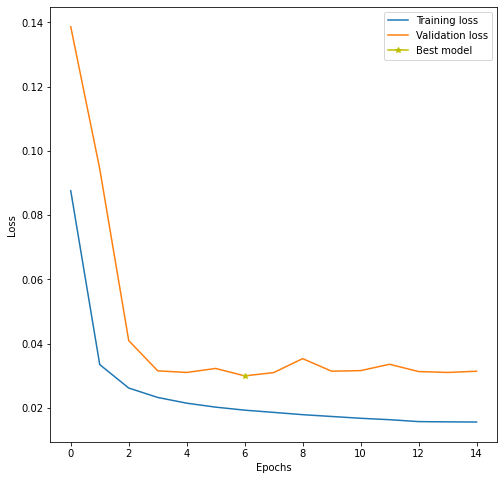

In [ ]:
if Train==True:
  plt.figure(figsize=(8, 8))
  plt.plot(model_history.history["loss"], label="Training loss")
  plt.plot(model_history.history["val_loss"], label="Validation loss")
  plt.plot( np.argmin(model_history.history["val_loss"]), np.min(model_history.history["val_loss"]), marker="*", color="y", label="Best model")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()


# Loading the trained model

In [ ]:
from tensorflow.keras.models import load_model
model = load_model(data_path+'checkpoint/keras.model', custom_objects={'focal_loss_fixed': focal_loss(gamma=2.,alpha=0.12)})

# Evaluation of the trained model

In [ ]:
#defining dice metric
smooth = 1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
  
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


#Confusion Matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [ ]:
def generate_report(true_seg,predicted_):
  thresh=0.5
  preds_rounded = np.round(predicted_>thresh)
  preds_rounded=preds_rounded.astype(np.float32)

  c=0  #0 or 1
  y_true = true_seg[:,:,:,c].flatten().astype(int)
  y_pred = preds_rounded[:,:,:,c].flatten()  #with a specific thresh
  y_pred_prob = predicted_[:,:,:,c].flatten()

  from sklearn import metrics
  acc=metrics.accuracy_score(y_true, y_pred, normalize=True)
  print('Accuracy = '+str(acc))

  dice_result=dice_coef(true_seg[:,:,:,0],preds_rounded[:,:,:,0])
  print('Dice='+str(K.eval(dice_result)))

  report=metrics.classification_report(y_true, y_pred, digits=4)
  print(report)


  #Plot ROC curve
  fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_prob, pos_label=1)
  roc_auc = metrics.auc(fpr, tpr)
  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange',
          lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend(loc="lower right")
  plt.show()


  from sklearn.metrics import confusion_matrix
  cnf_matrix = confusion_matrix(y_true, y_pred, labels=[1,0])
  #positive:vessel:1:mask:white
  #nagative:backgrnd:0:black

  np.set_printoptions(precision=2)
  class_names=['mask','background']

  # Plot non-normalized confusion matrix
  plt.figure()
  plot_confusion_matrix(cnf_matrix, classes=class_names,
                        title='Confusion matrix, without normalization');

  # Plot normalized confusion matrix
  plt.figure()
  plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                        title='Normalized confusion matrix');

  plt.show()

Evaluation on the TRAINING set
5/5 [==============================] - 0s 22ms/step
Accuracy = 0.9631553649902344
Dice=0.7953303
              precision    recall  f1-score   support

           0     0.9935    0.9670    0.9801   2456450
           1     0.6484    0.9057    0.7558    164990

    accuracy                         0.9632   2621440
   macro avg     0.8210    0.9364    0.8679   2621440
weighted avg     0.9718    0.9632    0.9660   2621440



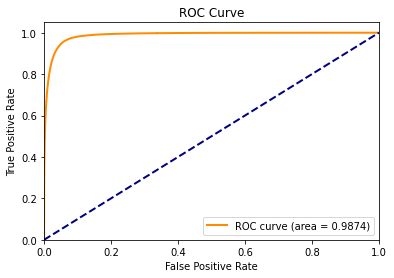

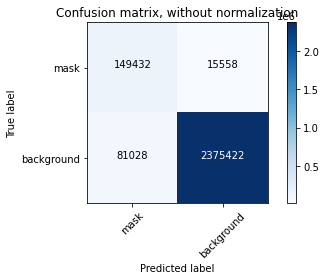

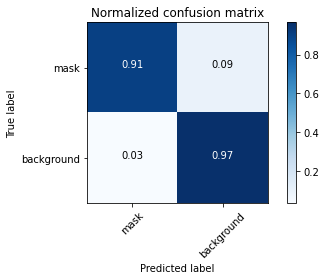

In [ ]:
print('Evaluation on the TRAINING set')
predicted_ = model.predict(TrainPatchImgEval)
generate_report(TrainPatchSegEval,predicted_)

Evaluation on the VALIDATION set
3/3 [==============================] - 0s 23ms/step
Accuracy = 0.9544593811035156
Dice=0.7311196
              precision    recall  f1-score   support

           0     0.9858    0.9651    0.9753   1223426
           1     0.6222    0.8051    0.7019     87294

    accuracy                         0.9545   1310720
   macro avg     0.8040    0.8851    0.8386   1310720
weighted avg     0.9616    0.9545    0.9571   1310720



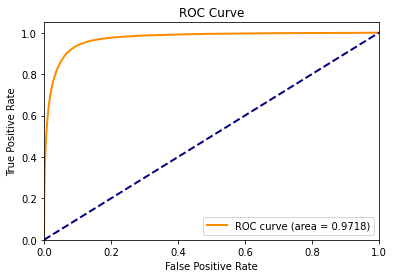

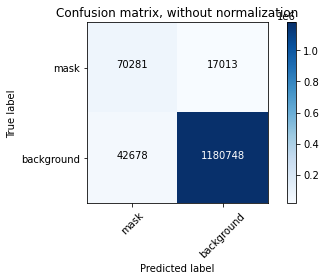

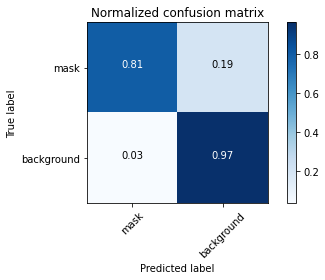

In [ ]:
print('Evaluation on the VALIDATION set')
predicted_ = model.predict(ValidPatchImg)
generate_report(ValidPatchSeg,predicted_)

Evaluation on the TEST set
3/3 [==============================] - 0s 23ms/step
Accuracy = 0.9605430603027344
Dice=0.7494508
              precision    recall  f1-score   support

           0     0.9904    0.9674    0.9787   1230579
           1     0.6307    0.8558    0.7262     80141

    accuracy                         0.9605   1310720
   macro avg     0.8105    0.9116    0.8525   1310720
weighted avg     0.9684    0.9605    0.9633   1310720



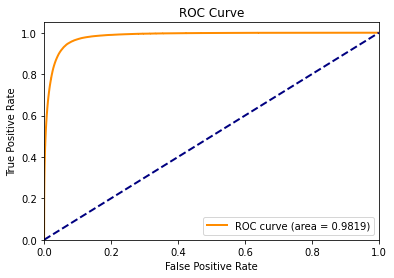

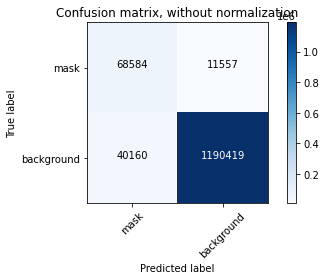

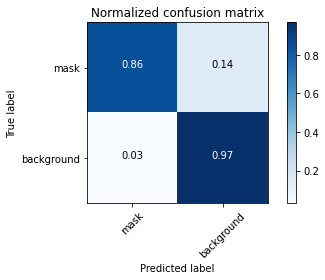

In [ ]:
print('Evaluation on the TEST set')
predicted_ = model.predict(TestPatchImg)
generate_report(TestPatchSeg,predicted_)

#Display on the test set

16/16 [==============================] - 1s 44ms/step


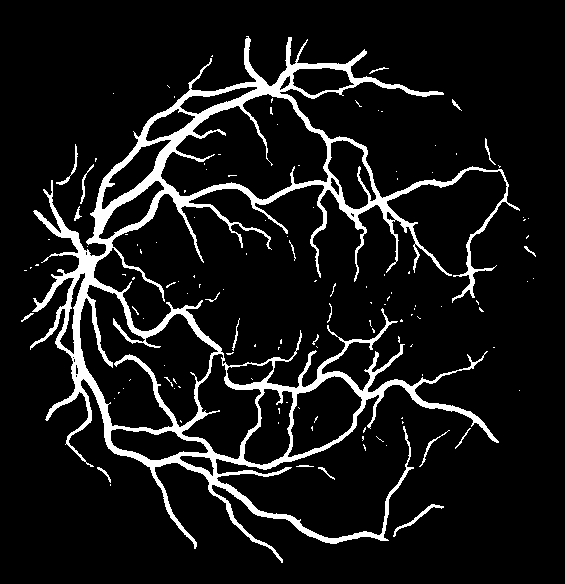

In [ ]:
imgs = test_imgs
#resize to 640*640
imgs_resized = np.ndarray((imgs.shape[0], 640, 640), dtype=np.uint8)
n=0
import cv2
for img in imgs:
  res = cv2.resize(img, dsize=(640, 640), interpolation=cv2.INTER_CUBIC)
  imgs_resized[n]=res
  n=n+1

#making patches of size 128*128
patch_size=128
step_size=128

from skimage.util.shape import view_as_windows
'''
imgs_patches = np.array([])
for i in range(imgs_resized.shape[0]):
  patches=view_as_windows(imgs_resized[i], (patch_size, patch_size), step=step_size)
  patches=patches.reshape(-1,patch_size,patch_size, order='A')
  if i==0:
    imgs_patches=patches
  else:
    imgs_patches=np.append(imgs_patches,patches,axis=0)
 '''

imgs_patches = np.ndarray((500, patch_size, patch_size), dtype=np.uint8)
p=0
for i in range(imgs_resized.shape[0]):
  #patches=view_as_windows(imgs_resized[i], (patch_size, patch_size), step=step_size)
  for r in range(5):
      for c in range(5):
        imgs_patches[p]=imgs_resized[i,r*128:(r+1)*128,c*128:(c+1)*128]
        p=p+1
    
imgs_patches = imgs_patches[:,:,:,np.newaxis]
imgs_patches = imgs_patches.astype('float32')
imgs_patches /=255.0



predicted_test = model.predict(imgs_patches)


#join patches together
full_segs = np.ndarray((20, 640, 640), dtype=np.float32)
p=0
num_tests=5
for i in range(num_tests):
  for r in range(5):
    for c in range(5):
      full_segs[i, r*128:(r+1)*128, c*128:(c+1)*128]=predicted_test[p,:,:,0]
      p=p+1

#resize back to 565*584
full_segs_resized = np.ndarray((full_segs.shape[0], 584, 565), dtype=np.float32)
n=0
for img in full_segs:
  res = cv2.resize(img, dsize=(565, 584), interpolation=cv2.INTER_CUBIC)
  full_segs_resized[n]=res
  n=n+1
  
#predicted seg -- rounded
thresh=0.5
full_segs_rounded = np.round(full_segs_resized>thresh)
w=Image.fromarray(255*full_segs_rounded[0].astype('uint8')).convert('L')
display(w)

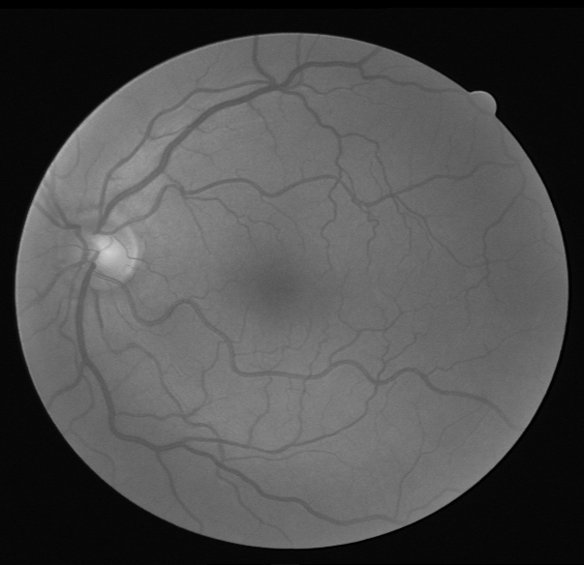

In [ ]:
w=Image.fromarray(test_imgs[0])
display(w)



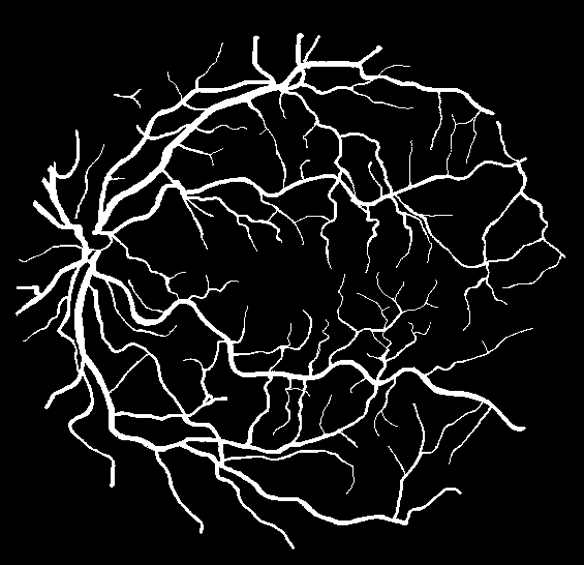

In [ ]:
w=Image.fromarray(test_segs[0]).convert('L')
display(w)
